In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#shareable links to get data file IDs
#validation: https://drive.google.com/open?id=1FIC8ATB-Iiy7WgczxsvEm6ynTC2Nffn2
#training: https://drive.google.com/open?id=1RuGTah6QFEzQdYC76D8HWLjqBgxMFitt

fileId = drive.CreateFile({'id': '1RuGTah6QFEzQdYC76D8HWLjqBgxMFitt'}) 
#DRIVE_FILE_ID is file id example: 1iytA1n2z4go3uVCwE_vIKouTKyIDjEq
print(fileId['title'])
fileId.GetContentFile('training50classes.zip')  # Save Drive file as a local file

fileId = drive.CreateFile({'id': '1FIC8ATB-Iiy7WgczxsvEm6ynTC2Nffn2'}) 
print(fileId['title'])
fileId.GetContentFile('validation50classes.zip')

!unzip training50classes.zip -d ./
!unzip validation50classes.zip -d ./



training50classes.zip
validation50classes.zip
Archive:  training50classes.zip
   creating: ./training50classes/airplane/
  inflating: ./training50classes/airplane/1.png  
  inflating: ./training50classes/airplane/11.png  
  inflating: ./training50classes/airplane/12.png  
  inflating: ./training50classes/airplane/13.png  
  inflating: ./training50classes/airplane/15.png  
  inflating: ./training50classes/airplane/16.png  
  inflating: ./training50classes/airplane/17.png  
  inflating: ./training50classes/airplane/19.png  
  inflating: ./training50classes/airplane/20.png  
  inflating: ./training50classes/airplane/21.png  
  inflating: ./training50classes/airplane/23.png  
  inflating: ./training50classes/airplane/24.png  
  inflating: ./training50classes/airplane/25.png  
  inflating: ./training50classes/airplane/27.png  
  inflating: ./training50classes/airplane/28.png  
  inflating: ./training50classes/airplane/29.png  
  inflating: ./training50classes/airplane/3.png  
  inflating: .

In [0]:
#shareable links to get data file IDs
#Model: https://drive.google.com/open?id=1bW_69FveLKZVTKLgtsisAJMV2zUMB9-u

fileId = drive.CreateFile({'id': '1bW_69FveLKZVTKLgtsisAJMV2zUMB9-u'}) 
print(fileId['title'])
fileId.GetContentFile('VGG19Berlin50cl.zip')  # Save Drive file as a local file

!unzip VGG19Berlin50cl.zip -d ./

VGG19Berlin50cl.zip
Archive:  VGG19Berlin50cl.zip
  inflating: ./VGG19Berlin50cl/VGG19BerlinDataset50clHistory.csv  
  inflating: ./VGG19Berlin50cl/VGG19BerlinDataset50cl-model1.h5  
  inflating: ./VGG19Berlin50cl/VGG19ModelBerlin50cl.h5  


In [0]:
from keras.models import load_model
model = load_model('VGG19Berlin50cl/VGG19ModelBerlin50cl.h5')

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
import os
import cv2
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser

from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from keras import backend as K
import tensorflow as tf

color = sns.color_palette()
%matplotlib inline
%config InlineBackend.figure_format="png"

# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

seed=1234

# Set the numpy seed
np.random.seed(seed)

# Set the random seed in tensorflow at graph level
tf.set_random_seed(seed)

# Make the augmentation sequence deterministic
aug.seed(seed)

In [0]:
import os
from pathlib import Path
training_data =Path('./training50classes/')
validation_data =Path('./validation50classes/')

#print(sorted(os.listdir(training_data)))
print(len(os.listdir(training_data)))
labels_name = sorted(os.listdir(training_data))
print(labels_name)

labels_num = []
i=1

for i in range(0,50):
  labels_num.append(i)
  
print(labels_num)

labels_dict = dict( zip(labels_name,labels_num))
print(labels_dict)

50
['airplane', 'ant', 'armchair', 'basket', 'bear (animal)', 'bell', 'blimp', 'bookshelf', 'bulldozer', 'butterfly', 'camel', 'cannon', 'carrot', 'cat', 'chair', 'church', 'comb', 'cow', 'crown', 'dragon', 'feather', 'foot', 'hamburger', 'head-phones', 'horse', 'ice-cream-cone', 'key', 'laptop', 'megaphone', 'mouse (animal)', 'panda', 'person sitting', 'power outlet', 'rainbow', 'sailboat', 'sea turtle', 'skull', 'speed-boat', 'squirrel', 'streetlight', 'suv', 'table', 'teddy-bear', 'tiger', 'tooth', 'train', 'truck', 'umbrella', 'walkie talkie', 'wine-bottle']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
{'airplane': 0, 'ant': 1, 'armchair': 2, 'basket': 3, 'bear (animal)': 4, 'bell': 5, 'blimp': 6, 'bookshelf': 7, 'bulldozer': 8, 'butterfly': 9, 'camel': 10, 'cannon': 11, 'carrot': 12, 'cat': 13, 'chair': 14, 'church': 15, 'comb': 16, 'cow

In [0]:
# Creating a dataframe for the training dataset
train_df = []
for folder in os.listdir(training_data):
    # Define the path to the images
    imgs_path = training_data / folder
    
    # Get the list of all the images stored in that directory
    imgs = sorted(imgs_path.glob('*.png'))
    
    # Store each image path and corresponding label 
    for img_name in imgs:
        train_df.append((str(img_name), labels_dict[folder]))


train_df = pd.DataFrame(train_df, columns=['image', 'label'], index=None)
# shuffle the dataset 
train_df = train_df.sample(frac=1.).reset_index(drop=True)

####################################################################################################

# Creating dataframe for validation data in a similar fashion
valid_df = []
for folder in os.listdir(validation_data):
    imgs_path = validation_data / folder
    imgs = sorted(imgs_path.glob('*.png'))
    for img_name in imgs:
        valid_df.append((str(img_name), labels_dict[folder]))

        
valid_df = pd.DataFrame(valid_df, columns=['image', 'label'], index=None)
# shuffle the dataset 
valid_df = valid_df.sample(frac=1.).reset_index(drop=True)

####################################################################################################

# How many samples do we have in our training and validation data?
print("Number of training samples: ", len(train_df))
print("Number of validation samples: ", len(valid_df))

# sneak peek of the training and validation dataframes
print("\n",train_df.head(), "\n")
print("=================================================================\n")
print("\n", valid_df.head())

Number of training samples:  3000
Number of validation samples:  1000

                                       image  label
0          training50classes/horse/8502.png     24
1    training50classes/speed-boat/15874.png     37
2        training50classes/armchair/488.png      2
3  training50classes/bear (animal)/1241.png      4
4          training50classes/camel/3249.png     10 



                                     image  label
0  validation50classes/butterfly/2855.png      9
1        validation50classes/cat/3903.png     13
2     validation50classes/basket/1083.png      3
3       validation50classes/suv/16835.png     40
4     validation50classes/table/17259.png     41


In [0]:
# some constants(not truly though!) 

# dimensions to consider for the images
img_rows, img_cols, img_channels = 224,224,3

# batch size for training  
batch_size=16

# total number of classes in the dataset
nb_classes=50

# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

In [0]:
def data_generator(data, batch_size, is_validation_data=False):
    # Get total number of samples in the data
    n = len(data)
    nb_batches = int(np.ceil(n/batch_size))

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, img_rows, img_cols, img_channels), dtype=np.float32)
    batch_labels = np.zeros((batch_size, nb_classes), dtype=np.float32)
    
    while True:
        if not is_validation_data:
            # shuffle indices for the training data
            np.random.shuffle(indices)
            
        for i in range(nb_batches):
            # get the next batch 
            next_batch_indices = indices[i*batch_size:(i+1)*batch_size]
            
            # process the next batch
            for j, idx in enumerate(next_batch_indices):
                img = cv2.imread(data.iloc[idx]["image"])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                label = data.iloc[idx]["label"]
                
                if not is_validation_data:
                    img = seq.augment_image(img)
                
                img = cv2.resize(img, (img_rows, img_cols)).astype(np.float32)
                batch_data[j] = img
                batch_labels[j] = to_categorical(label,num_classes=nb_classes)
            
            batch_data = preprocess_input(batch_data)
            yield batch_data, batch_labels

In [0]:
#training data generator 
train_data_gen = data_generator(train_df, batch_size, is_validation_data=False)

# validation data generator 
valid_data_gen = data_generator(valid_df, batch_size, is_validation_data=True)

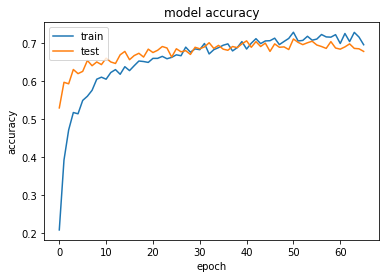

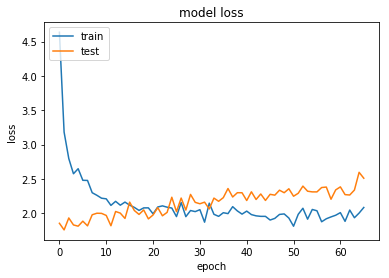

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# Read history csv
df_hist = pd.read_csv('VGG19Berlin50cl/VGG19BerlinDataset50clHistory.csv')

# summarize history for accuracy
plt.plot(df_hist['acc'].tolist())
plt.plot(df_hist['val_acc'].tolist())
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(df_hist['loss'].tolist())
plt.plot(df_hist['val_loss'].tolist())
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
nb_train_steps = int(np.ceil(len(train_df)/batch_size))
nb_valid_steps = int(np.ceil(len(valid_df)/batch_size))

# What is the final loss and accuracy on our validation data?
valid_loss, valid_acc = model.evaluate_generator(valid_data_gen, steps=nb_valid_steps)
print(f"Final validation accuracy: {valid_acc*100:.2f}%")
print(f"Final validation loss: {valid_loss:.2f}%")

Final validation accuracy: 71.03%
Final validation loss: 2.38%


validation50classes/carrot/3707.png


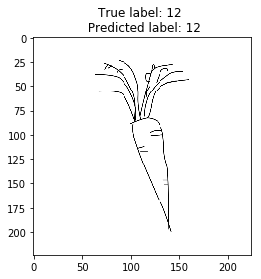

In [0]:
idx = 150

print(valid_df.iloc[idx]['image'])

# select the sample and read the corresponding image and label
sample_image2 = cv2.imread(valid_df.iloc[idx]['image'])
sample_image2 = cv2.cvtColor(sample_image2, cv2.COLOR_BGR2RGB)
sample_image2 = cv2.resize(sample_image2, (img_rows, img_cols))
sample_label2 = valid_df.iloc[idx]["label"]
    
# pre-process the image
sample_image_processed2 = np.expand_dims(sample_image2, axis=0)
sample_image_processed2 = preprocess_input(sample_image_processed2)
    
# get the label predicted by our original model
pred_label2 = np.argmax(model.predict(sample_image_processed2), axis=-1)[0]
    
plt.imshow(sample_image2)
plt.title(f"True label: {sample_label2} \n Predicted label: {pred_label2}")
plt.show()